In [1]:
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from lightning_models import AELSTMPredictor
from torchinfo import summary

In [2]:
model = AELSTMPredictor(data_path = 'Dataset/IKCO1.csv',      
                        learning_rate = 3e-4,
                        weight_decay = 0.001,
                        split = [0.70, 0.15, 0.15],
                        batch_size = 128, 
                        input_size = 5,
                        code_size = 2,
                        intr_size = 3,
                        hidden_size = 256,
                        num_layers = 3,
                        prob = 0,
                        timestep = 90,
                        k_days = 30)


summary(model, input_size = (128, 90, 5))

Layer (type:depth-idx)                   Output Shape              Param #
AELSTMPredictor                          --                        --
├─AELSTM: 1-1                            [128, 30]                 --
│    └─Encoder: 2-1                      [128, 90, 2]              --
│    │    └─LSTM: 3-1                    [128, 90, 3]              120
│    │    └─LSTM: 3-2                    [128, 90, 2]              56
│    └─Decoder: 2-2                      [128, 90, 5]              --
│    │    └─LSTM: 3-3                    [128, 90, 3]              84
│    │    └─LSTM: 3-4                    [128, 90, 5]              200
│    └─forecastLSTM: 2-3                 [128, 30]                 --
│    │    └─LSTM: 3-5                    [128, 90, 256]            1,318,912
│    │    └─Linear: 3-6                  [128, 32]                 8,224
│    │    └─Linear: 3-7                  --                        (recursive)
│    │    └─Dropout: 3-8                 [128, 32]              

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath = 'aelstmpredictor',
                                    filename = "my_checkpoint.ckpt",
                                    every_n_epochs = 1,
                                    monitor = 'val_loss',
                                    mode = 'min')

early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00,
                                    patience = 20,
                                    verbose = False,
                                    mode = "min")

logger = TensorBoardLogger('aelstmpredictor-logs/', name = 'aelstmpredictor', version = 0)

In [ ]:
trainer = Trainer(
    default_root_dir = 'aelstmpredictor-logs/',
    gpus = (1 if torch.cuda.is_available() else 0),
    callbacks = [checkpoint_callback, early_stop_callback],
    max_epochs = 100,
    logger = logger)

trainer.fit(model = model)

In [ ]:
trainer.test(datamodule = model)

In [20]:
from utils import train_val_test_split, return_based, log_return_based, returns_direction

model = model.load_from_checkpoint("aelstmpredictor\my_checkpoint.ckpt.ckpt")

df = pd.read_csv('Dataset\PARK1.csv', index_col = [0])

df['<CLOSE>_rb'] = pd.DataFrame(return_based(df['<CLOSE>'], 21))
df['<OPEN>_rb'] = pd.DataFrame(return_based(df['<OPEN>'], 21))
df['<HIGH>_rb'] = pd.DataFrame(return_based(df['<HIGH>'], 21))
df['<LOW>_rb'] = pd.DataFrame(return_based(df['<LOW>'], 21))
df['<VOL>_rb'] = pd.DataFrame(log_return_based(df['<VOL>'], 21))

df['returns'] = pd.DataFrame(returns_direction(df))

df[['returns']] = df[['returns']].rolling(90).median()
df[21:]

input = df[['<OPEN>_rb', '<HIGH>_rb', '<LOW>_rb', '<CLOSE>_rb', '<VOL>_rb']][-90:]
input = model.scaler_X.transform(input)
input = np.array(input).astype(np.float32)
input = input.reshape(1, input.shape[0], input.shape[1])

input = torch.tensor(input)
input

tensor([[[0.1797, 0.1073, 0.1862, 0.1449, 0.3570],
         [0.1449, 0.1079, 0.1534, 0.1330, 0.4011],
         [0.1330, 0.1072, 0.1451, 0.1575, 0.4026],
         [0.1575, 0.1302, 0.2288, 0.2029, 0.4014],
         [0.2029, 0.1474, 0.1974, 0.1750, 0.3561],
         [0.1750, 0.1413, 0.1755, 0.1676, 0.3726],
         [0.1676, 0.0949, 0.1569, 0.1334, 0.4330],
         [0.1334, 0.0817, 0.1494, 0.1015, 0.4718],
         [0.1015, 0.0880, 0.1749, 0.1374, 0.3388],
         [0.1374, 0.1104, 0.2154, 0.1931, 0.3680],
         [0.1931, 0.1427, 0.1995, 0.2350, 0.4778],
         [0.2350, 0.1599, 0.2342, 0.2028, 0.4305],
         [0.2028, 0.1329, 0.2180, 0.2006, 0.4736],
         [0.2006, 0.1462, 0.2328, 0.2312, 0.4374],
         [0.2312, 0.1727, 0.2882, 0.2608, 0.4809],
         [0.2608, 0.1944, 0.2776, 0.2412, 0.4476],
         [0.2412, 0.1601, 0.2429, 0.2116, 0.4287],
         [0.2116, 0.1590, 0.2241, 0.2499, 0.4538],
         [0.2499, 0.1848, 0.3388, 0.2937, 0.3793],
         [0.2937, 0.2268, 0.333

In [21]:
model.eval()
with torch.no_grad():
    
    output, _ = model(torch.tensor(input)) 

preds = output.squeeze()
preds = np.array(preds) 
preds

C:\Users\YEGYAN~1\AppData\Local\Temp/ipykernel_7292/3936213795.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output, _ = model(torch.tensor(input))


array([0.49469513, 0.492138  , 0.49360082, 0.4909844 , 0.49227387,
       0.49349064, 0.4933506 , 0.49380806, 0.49436617, 0.49134094,
       0.4923673 , 0.49460185, 0.49157414, 0.49150997, 0.49398276,
       0.4914398 , 0.49416387, 0.4909591 , 0.49416536, 0.49325848,
       0.4922824 , 0.49208546, 0.49151117, 0.4910807 , 0.49413693,
       0.49144608, 0.49260485, 0.49064195, 0.4933196 , 0.49441773],
      dtype=float32)

In [22]:
preds = pd.DataFrame(preds, columns = ['returns'])
preds[['returns']] = model.scaler_y.inverse_transform(preds[['returns']])
preds

,returns
0,35.897339
1,23.797007
2,30.719057
3,18.338228
4,24.439938
5,30.197691
6,29.535015
7,31.699743
8,34.340710
9,20.025305


<AxesSubplot:>

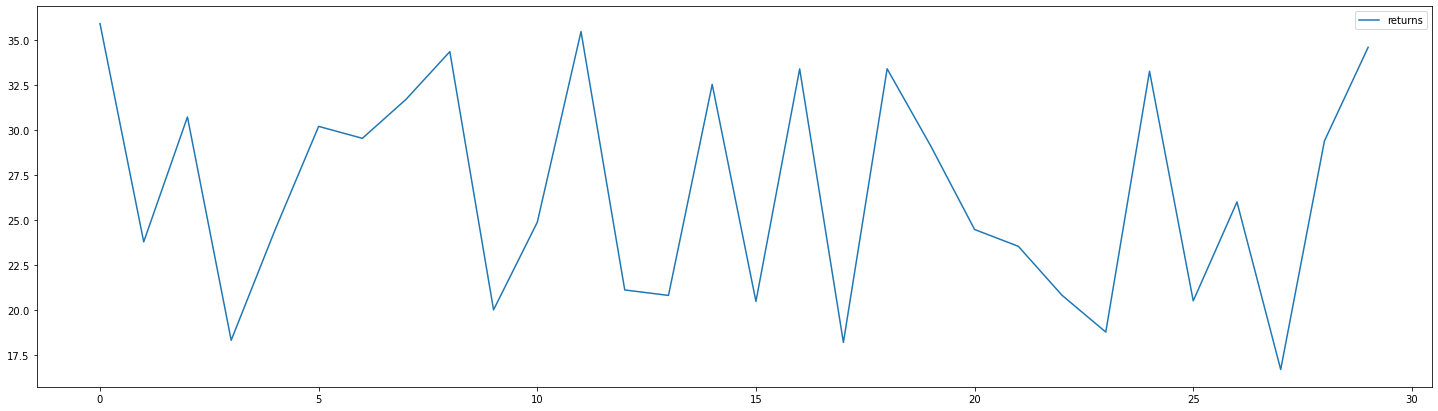

In [23]:
preds.plot(figsize = (25, 7))

Text(0.5, 0, 'Day Count')

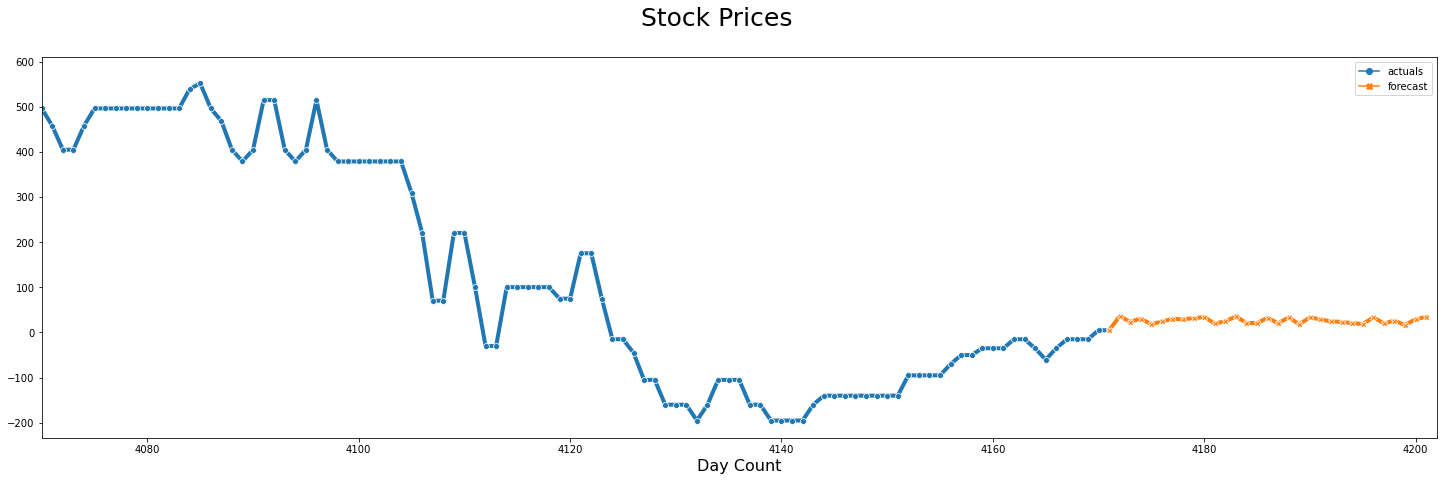

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

my_df = pd.DataFrame()

actuals = df['returns']

list = [np.nan for i in range(len(df) - 1)]
list.append(actuals[len(actuals) - 1])

for i in range(30):
    actuals = actuals.append(pd.Series(pd.NA), ignore_index=True)

my_df['actuals'] = actuals
my_df['actuals'] = pd.to_numeric(my_df['actuals'])

target_series = preds['returns']

for x in target_series:
    list.append(x)

my_df['forecast'] = pd.Series(list)
my_df.loc[len(df) - 1, 'forecast'] = actuals[len(df) - 1]


fig = plt.figure(figsize=(25, 7))
sns.lineplot(data = my_df, markers = True, dashes = False, linewidth = 4)
sns.color_palette("flare", as_cmap=True)
plt.xlim([4070, len(my_df)]) #len(my_df) - next_k_days - 10
fig.suptitle('Stock Prices', fontsize = 25)
plt.xlabel('Day Count', fontsize = 16)